# **Trabajo Práctico N°1 : Reservas de Hotel**

**Checkpoint 4**

Grupo: N°06 - Pandatos

Integrantes: 
* Juan Sebastian Makkos 
* Valeria Brzoza 
* Rodolfo Valentin Albornoz Tomé

Importamos las librerias correspondientes que vamos a utilizar

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning) 

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(1)
tf.random.set_seed(1) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos el dataset de hotels_train y de hotels_test

In [ ]:
ds_hotels_train = pd.read_csv('/content/drive/MyDrive/TP1_Orga/ds_trabajo_procesado.csv')
ds_trabajo = ds_hotels_train.copy()
ds_hotels_test = pd.read_csv('/content/drive/MyDrive/TP1_Orga/hotels_test.csv')
ds_test = ds_hotels_test.copy()

Sacamos del dataset de test las columnas eliminadas en el dataset de trabajo debido al análisis exploratorio

In [ ]:
ds_test = ds_test[['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr',
       'total_of_special_requests', 'id']]

Guardamos una copia de la columna id del dataset de test y luego la eliminamos del mismo dataset para evitar errores

In [ ]:
ds_test_id = ds_test['id'].copy()
ds_test = ds_test.drop(['id'], axis = 'columns', inplace = False)

Eliminamos las columnas Unnamed: 0 y id ya que no los necesitamos en el dataset de train

In [ ]:
ds_trabajo = ds_trabajo.drop(['Unnamed: 0'], axis = 'columns', inplace = False)
ds_trabajo = ds_trabajo.drop(['id'], axis = 'columns', inplace = False)

Categorizamos todas las variables categoricas con label encoder tanto en el dataset de test como el de train

In [ ]:
variables_categoricas = ['hotel', 'arrival_date_year', 'arrival_date_month', 
                         'arrival_date_day_of_month', 'meal', 'country',
                         'is_repeated_guest', 'reserved_room_type', 
                         'assigned_room_type', 'deposit_type', 'agent', 
                         'customer_type']

label_encoder = preprocessing.LabelEncoder()

for columna in ds_trabajo.columns:
  if columna in variables_categoricas:
    ds_trabajo[columna] = label_encoder.fit_transform(ds_trabajo[columna]) 
for columna in ds_test.columns:
  if columna in variables_categoricas:
    ds_test[columna] = label_encoder.fit_transform(ds_test[columna])

Manipulamos el dataset de trabajo para poder separarlo en 2 partes, un dataset con el atributo a predecir, y un dataset con el resto de atributos

In [ ]:
target = 'is_canceled'

ds_trabajo_x = ds_trabajo.drop([target], axis = 'columns', inplace = False)
ds_trabajo_y = ds_trabajo[target].copy()

# Red Neuronal

## **Construcción del modelo**

Realizamos la división del dataset de trabajo en train y test, dividiendo en proporción 70/30

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size = 0.3, random_state = 1, stratify = ds_trabajo_y)

Creamos el escalador para normalizar los datos

In [ ]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(x_train)
x_train_norm = standard_scaler.transform(x_train)
x_test_norm = standard_scaler.transform(x_test)

Establecemos los valores para las capas del modelo a entrenar.

In [ ]:
cant_clases = len(np.unique(y_train))
d_in = len(x_train.columns)

Ahora entrenamos varios modelos para observar cuál predice mejor segun su arquitectura, parámetros, optimizador y demás

### Modelo 1

Probamos un modelo con activacion sigmoid


In [ ]:
modelo_1 = keras.Sequential([
    keras.layers.Dense(16, input_shape = (d_in, )),
    keras.layers.Dense(1, activation = 'sigmoid')
])

modelo_1.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 16)                400       
                                                                 
 dense_97 (Dense)            (None, 1)                 17        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


Entrenamos la red neuronal con la función de perdida binary_crossentropy y con una cantidad de epochs y batch_size con valor de 100

In [ ]:
modelo_1.compile(
  optimizer = keras.optimizers.SGD(learning_rate = 0.01), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy'],
)

cant_epochs_1 = 100
modelo_1_entrenado = modelo_1.fit(x_train_norm, y_train, epochs = cant_epochs_1, batch_size = 100, verbose = False)

### Modelo 2

Probamos un modelo con diferentes parametros con respecto al modelo 1

In [ ]:
modelo_2 = keras.Sequential([
    keras.layers.Dense(2, input_shape = (d_in, ), kernel_initializer = 'uniform'),
    keras.layers.Dense(cant_clases - 1, activation = 'sigmoid')])

modelo_2.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 2)                 50        
                                                                 
 dense_119 (Dense)           (None, 1)                 3         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


Entrenamos al modelo bajando el learning rate

In [ ]:
modelo_2.compile(
  optimizer = keras.optimizers.SGD(learning_rate = 0.0001), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy'],
)

cant_epochs_2 = 100

modelo_2_historia = modelo_2.fit(x_train_norm, y_train, epochs = cant_epochs_2, batch_size = 100, verbose = False)

### Modelo con validación cruzada

Creamos el modelo para luego optimizar los parametros con gridSearchCV y posteriormente lo entrenamos

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

Creamos la función que nos crea el modelo al que le vamos a hacer cross validation

In [ ]:
def create_model():
    modelo= keras.Sequential([
    keras.layers.Dense(2,input_shape = (d_in,), activation = 'relu', kernel_initializer = 'uniform'),
    keras.layers.Dense(cant_clases, activation = 'softmax')])
    
    modelo.compile(
      optimizer = keras.optimizers.SGD(learning_rate = 0.0001), 
      loss = 'categorical_crossentropy', 
      metrics = ['accuracy'], 
    )
    
    return modelo

Creamos el modelo

In [ ]:
modelo_cv = KerasClassifier(build_fn = create_model)

Ahora realizamos el grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

epochs = [10]
batches = [10]

param_grid = dict(epochs = epochs, batch_size = batches)

grid = GridSearchCV(estimator = modelo_cv, param_grid = param_grid)
grid_result = grid.fit(x_train_norm, y_train)

Epoch 1/10
3012/3012 [==============================] - 6s 2ms/step - loss: 0.6944 - accuracy: 0.5196
Epoch 2/10
3012/3012 [==============================] - 7s 2ms/step - loss: 0.6834 - accuracy: 0.5197
Epoch 3/10
3012/3012 [==============================] - 5s 2ms/step - loss: 0.6703 - accuracy: 0.5197
Epoch 4/10
3012/3012 [==============================] - 6s 2ms/step - loss: 0.6587 - accuracy: 0.5197
Epoch 5/10
3012/3012 [==============================] - 10s 3ms/step - loss: 0.6484 - accuracy: 0.5966
Epoch 6/10
3012/3012 [==============================] - 12s 4ms/step - loss: 0.6391 - accuracy: 0.6418
Epoch 7/10
3012/3012 [==============================] - 6s 2ms/step - loss: 0.6306 - accuracy: 0.6624
Epoch 8/10
3012/3012 [==============================] - 10s 3ms/step - loss: 0.6227 - accuracy: 0.6692
Epoch 9/10
3012/3012 [==============================] - 6s 2ms/step - loss: 0.6155 - accuracy: 0.6745
Epoch 10/10
753/753 [==============================] - 1s 2ms/step - loss: 0.60

Imprimimos el modelo con la mejor métrica y los mejores parámetros

In [ ]:
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor modelo: 0.699089 {'batch_size': 10, 'epochs': 10}


Sacamos las predicciones de cada modelo y nos quedamos con el mejor (Modelo 1)

In [ ]:
y_pred_mod_1 = modelo_1.predict(x_test_norm)
y_pred_mod_1_cat = np.where(y_pred_mod_1 > 0.4,1,0)

505/505 [==============================] - 1s 1ms/step


In [ ]:
y_pred_mod_2 = modelo_2.predict(x_test_norm)
y_pred_mod_2_cat = np.where(y_pred_mod_2>0.4,1,0)

505/505 [==============================] - 3s 6ms/step


In [ ]:
y_pred_mod_cv = grid.predict(x_test_norm)

505/505 [==============================] - 1s 2ms/step


# **Performance del modelo**

Matriz de confusion

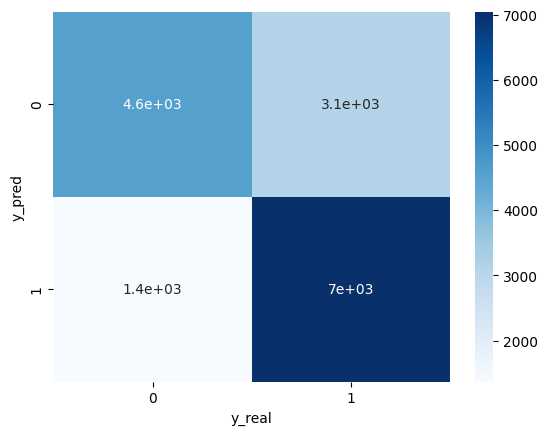

In [ ]:
ds_validacion = pd.DataFrame(y_pred_mod_1_cat, y_test).reset_index()
ds_validacion.columns = ['y_pred','y_real']

tabla_iris=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla_iris, annot = True, cmap = 'Blues')
plt.show()

Métricas en el conjunto de evaluación

In [ ]:
accuracy = accuracy_score(y_test, y_pred_mod_1_cat)
recall = recall_score(y_test, y_pred_mod_1_cat)
f1 = f1_score(y_test, y_pred_mod_1_cat)

print("Accuracy: "+ str(accuracy))
print("Recall: "+ str(recall))
print("f1 score: "+ str(f1))

Accuracy: 0.6945202082816762
Recall: 0.6260549150124807
f1 score: 0.6812831457767429


Metricas de test del modelo

In [ ]:
print(classification_report(y_test, y_pred_mod_1_cat))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      7719
           1       0.69      0.84      0.76      8413

    accuracy                           0.72     16132
   macro avg       0.73      0.72      0.71     16132
weighted avg       0.73      0.72      0.72     16132



Metricas de train del modelo

In [ ]:
print(classification_report(y_train, np.where((modelo_1.predict(x_train_norm)) > 0.4,1,0)))

1177/1177 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.60      0.68     18011
           1       0.70      0.83      0.76     19628

    accuracy                           0.72     37639
   macro avg       0.73      0.72      0.72     37639
weighted avg       0.73      0.72      0.72     37639



Viendo el valor de las métricas para cada conjunto de datos, y con la matriz de confusión, podemos decir que, entre los label 0 y 1, no hay una clara diferencia entre ambos.

Tambien coincide que en ambos casos, para el conjunto de entrenamiento como para el conjunto de test, el label 1 es el que tiene mayor valor para recall y f1-score y coincide con la mayor cantidad de registros con este label.

Por ultimo, como podemos observar, el F1-score en datos de entrenamiento es similar al F1-score con datos nuevos de testeo, esto es un buen indicio que el modelo no esta overfiteado.

# **Submission y exportación del modelo entrenado**

Exportamos el mejor modelo entrenado y realizamos la submission del mismo

In [ ]:
import joblib

joblib.dump(grid, '/content/drive/MyDrive/TP1_Orga/clasificador_redes_neuronales.joblib')

['/content/drive/MyDrive/TP1_Orga/clasificador_redes_neuronales.joblib']

Escalamos el dataset de test ya que si no la predicción da malos valores

In [ ]:
standard_scaler = preprocessing.StandardScaler()
ds_test_norm = standard_scaler.fit_transform(ds_test)

Realizamos la predicción con el modelo que nos dió mejores valores (Modelo 1)

In [ ]:
y_pred_red = modelo_1.predict(ds_test_norm)
y_pred_red_cat = np.where(y_pred_red > 0.4, 1,0)

y_pred_red_array = []
for i in range(len(y_pred_red_cat)):
  y_pred_red_array.append(y_pred_red_cat[i][0])

830/830 [==============================] - 2s 2ms/step


Creamos el archivo csv para la submission

In [ ]:
df_submission_red = pd.DataFrame({'id': ds_test_id, target: y_pred_red_array})

df_submission_red.to_csv('/content/drive/MyDrive/TP1_Orga/submissions/submission_red_neuronal_modelo_1.csv', index = False)